# Evaluate CLIP on Test Dataset

- Got inspiration for finteuning here: 
    - https://github.com/sachinruk/blog/blob/master/_notebooks/2021-03-07-CLIP.ipynb
    - https://github.com/huggingface/transformers/blob/main/examples/pytorch/contrastive-image-text/run_clip.py
- Dataset: 
    - https://huggingface.co/datasets/AlekseyDorkin/extended_tweet_emojis/tree/main


In [2]:
# you might want to restart the kernel after installation is complete.
!pip install transformers evaluate pillow datasets pycm ipywidgets jupyter jupyter_client --upgrade --quiet

## 1. Getting Dataset

In [4]:
from datasets import load_dataset

In [6]:
dataset = load_dataset("AlekseyDorkin/extended_tweet_emojis")

Using custom data configuration AlekseyDorkin--extended_tweet_emojis-4eb99ce06d465da0
Reusing dataset parquet (/root/.cache/huggingface/datasets/AlekseyDorkin___parquet/AlekseyDorkin--extended_tweet_emojis-4eb99ce06d465da0/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/2 [00:00<?, ?it/s]

In [38]:
SEED = 42 # use the same seed as in step 01
TEST_SIZE = 0.1 # use the same test size as in step 01
train_dataset_full = dataset["train"]
train_test_dataset = train_dataset_full.train_test_split(test_size=TEST_SIZE, seed=SEED)
test_dataset = train_test_dataset["test"]

## 1.1 Imbalanced Dataset

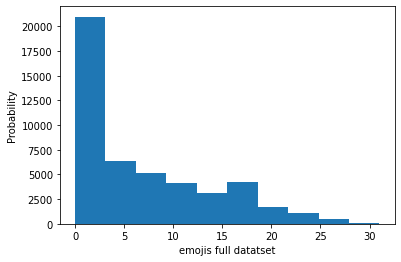

In [40]:
import matplotlib.pyplot as plt
plt.hist(train_dataset_full["label"])  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('emojis full datatset');

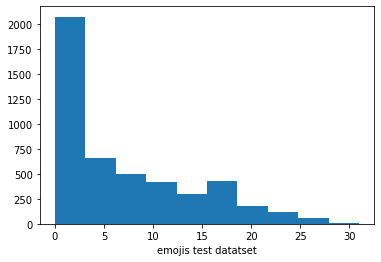

In [39]:
plt.hist(test_dataset["label"])  # density=False would make counts
plt.xlabel('emojis test datatset');

In [11]:
from PIL import Image
emojis_as_images = [Image.open(f"emojis/{i}.png") for i in range(32)]

## 2. Evaluate Test Dataset

In [12]:
from transformers import CLIPProcessor, CLIPModel
import torch

In [13]:
MODEL = "checkpoints/checkpoint-2000"
PROCESSOR = "openai/clip-vit-base-patch32"
predictions = []
references = []
SHARDS = 20
# not fully understanding this, but with torch.no_grad
# our GPU does not run out of memory.
with torch.no_grad():
    for i in range(SHARDS):
        chunk = test_dataset.shard(num_shards=SHARDS, index=i)
        chunk_text = chunk["text"]
        chunk_label = chunk["label"]
        model = CLIPModel.from_pretrained(MODEL).to("cuda")
        processor = CLIPProcessor.from_pretrained(PROCESSOR)
        inputs = processor(text=chunk_text, images=emojis_as_images, return_tensors="pt", padding=True, truncation=True)
        outputs = model(**inputs.to("cuda"))
        # we want the probability for each emoji per sentence.
        logits_per_text = outputs.logits_per_text
        # we take the softmax to get the label probabilities
        probs = logits_per_text.softmax(dim=1)
        predictions_for_chunk = [torch.argmax(prob).item() for prob in probs]
        predictions.extend(predictions_for_chunk)
        references.extend(chunk_label)
        print(f"total predictions so far: {len(predictions)}")
        torch.cuda.empty_cache()

/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2022-07-23 13:25:01.809: W smdistributed/modelparallel/torch/nn/predefined_hooks.py:47] Found unsupported HuggingFace version 4.20.1 for automated tensor parallelism. HuggingFace modules will not be automatically distributed. You can use smp.tp_register_with_module API to register desired modules for tensor parallelism, or directly instantiate an smp.nn.DistributedModule. Supported HuggingFace transformers versions for automated tensor parallelism: ['4.16.2']
[2022-07-23 13:25:01.862 pytorch-1-10-gpu-py-ml-g4dn-xlarge-5086b554a12da40ba14f4b244605:23 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-23 13:25:01.997 pytorch-1-10-gpu-py-ml-g4dn-xlarge-5086b554a12da40ba14f4b244605:23 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/opt/conda/lib/python3.8/site-packages/smdebug-1.0.13b20220304-py3.8.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


total predictions so far: 238


/opt/conda/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


total predictions so far: 476
total predictions so far: 714
total predictions so far: 952
total predictions so far: 1189
total predictions so far: 1426
total predictions so far: 1663
total predictions so far: 1900
total predictions so far: 2137
total predictions so far: 2374
total predictions so far: 2611
total predictions so far: 2848
total predictions so far: 3085
total predictions so far: 3322
total predictions so far: 3559
total predictions so far: 3796
total predictions so far: 4033
total predictions so far: 4270
total predictions so far: 4507
total predictions so far: 4744


## 4. Evaluate Predictions

In [19]:
import evaluate
precision_metric = evaluate.load("precision")
# Micro-averaging will put more emphasis on the common classes in the data set. 
# Rare labels shouldn’t influence the overall precision metric heavily.
results = precision_metric.compute(references=references, predictions=predictions, average="micro")
print("""We calculate the precision for prediction the right emoji. 
The following number show the percentage of correctly predicted (TP) 
compared to wrongly + correctly predcted (FP + TP). \n""")
print(results)

We calculate the precision for prediction the right emoji. 
The following number show the percentage of correctly predicted (TP) 
compared to wrongly + correctly predcted (FP + TP). 

{'precision': 0.8109190556492412}


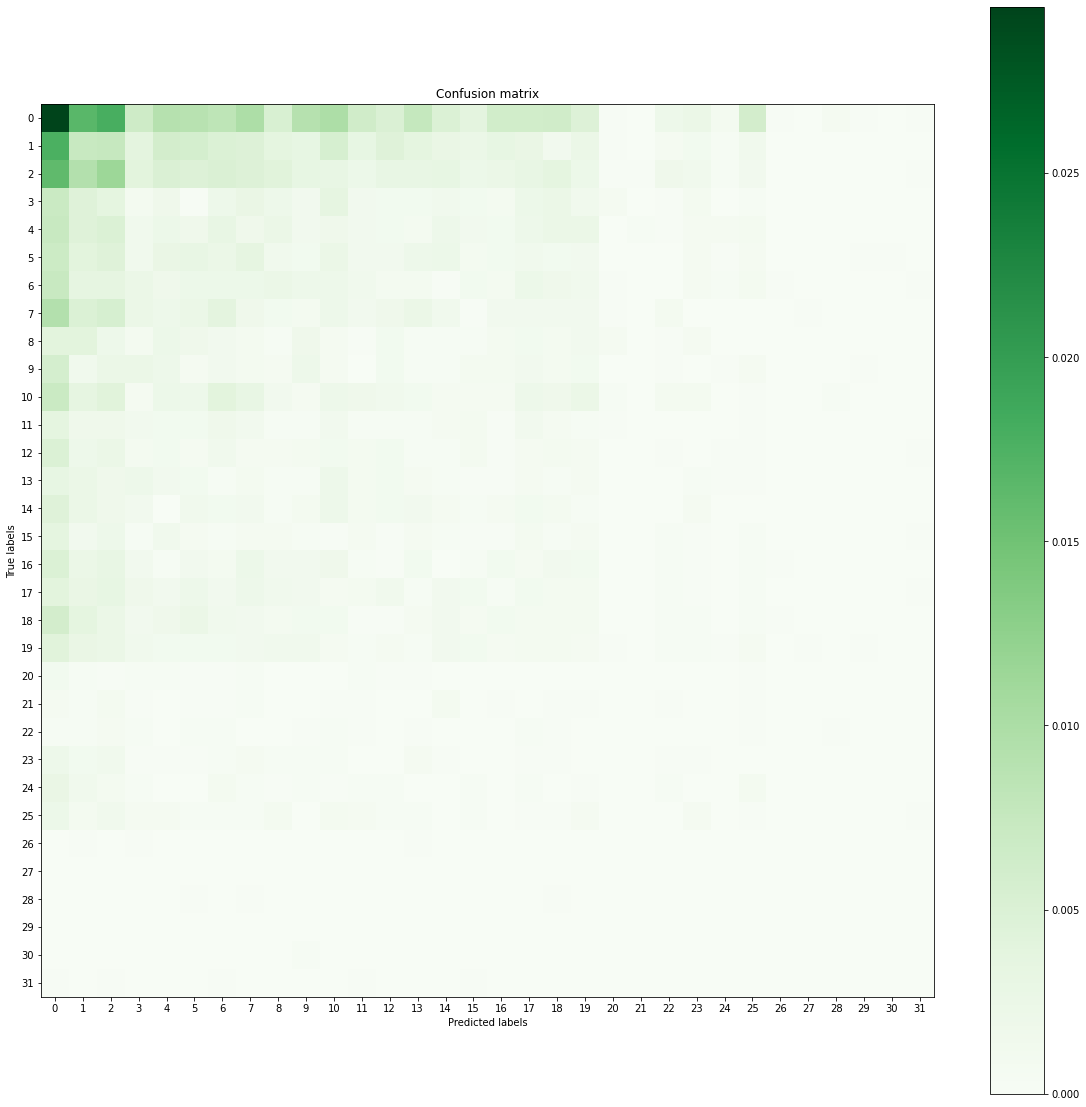

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Create confusion matrix
confusion_mat = confusion_matrix(test_dataset["label"], predictions, normalize="all")

# Visualize confusion matrix
plt.figure(figsize = (20,20))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Greens)
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(stop=len(emojis_as_images))
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()


In [16]:
import pandas as pd
df_mapping = pd.read_table("mapping.txt", header=None)

In [13]:
df_mapping[1][1].encode('unicode-escape').decode('ASCII')

'\\U0001f60d'

In [14]:
len(df_mapping[1].to_list())

32